In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import edward2 as ed

from inferences import JCAdersarialVI

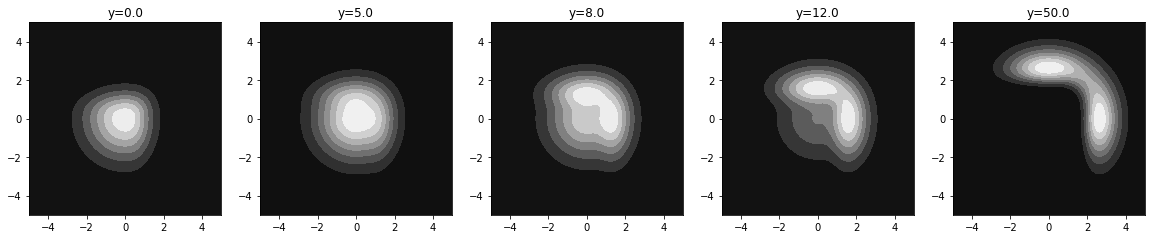

In [2]:
beta_0 = 3
beta_1 = 1
def likelihood(x, y):
    beta = beta_0 + (beta_1*(x**3).clip(0,np.Inf).sum(axis=0))
    return -np.log(beta) - y/beta

xmin = -5
xmax = 5
xrange = np.linspace(xmin,xmax,300)
x = np.repeat(xrange[:,None],300,axis=1)
x = np.concatenate([[x.flatten()],[x.T.flatten()]])
prior_variance = 2
logprior = -(x**2).sum(axis=0)/2/prior_variance
plt.subplots(figsize=(20,4))
y = [0., 5., 8., 12., 50.]
for i, yi in enumerate(y):
    plt.subplot(1,5,i+1)
    plt.contourf(xrange, xrange, np.exp(logprior + likelihood(x, yi)).reshape(300,300), cmap='gray')
    plt.title('y={}'.format(yi))
    plt.axis('square');
    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])

# Fitting Posterior

In [3]:
def RecognitionModel(input_shape, noise_dim, latent_dim):
    input_x = tf.keras.Input(shape=input_shape)
    # Preprocess to [0, 1], E[x] = 8 --> apply exp pdf with lambda=1/8
    x = tf.keras.layers.Lambda(lambda x: tf.math.exp(-0.125*x))(input_x)
    x = tf.keras.layers.Dense(16, activation=tf.nn.elu)(x)
    x = tf.keras.layers.Dense(32, activation=tf.nn.elu)(x)

    input_z = tf.keras.Input(shape=(noise_dim,))
    z = tf.keras.layers.Dense(32, activation=tf.nn.elu)(input_z)

    xz = tf.keras.layers.Add()([x, z])
    xz = tf.keras.layers.Dense(32, activation=tf.nn.elu)(xz)
    xz = tf.keras.layers.Dense(64, activation=tf.nn.elu)(xz)
    outputs = tf.keras.layers.Dense(latent_dim)(xz)

    return tf.keras.Model(inputs=[input_x, input_z], outputs=outputs)

def Discriminator(obs_shape, latent_shape):
    input_x = tf.keras.Input(shape=obs_shape)
    # Preprocess to [0, 1]
    x = tf.keras.layers.Lambda(lambda x: tf.math.exp(-0.125*x))(input_x)
    x = tf.keras.layers.Dense(16, activation=tf.nn.elu)(x)
    x = tf.keras.layers.Dense(32, activation=tf.nn.elu)(x)

    input_z = tf.keras.Input(shape=latent_shape)
    z = tf.keras.layers.Dense(16, activation=tf.nn.elu)(input_z)
    z = tf.keras.layers.Dense(32, activation=tf.nn.elu)(z)

    xz = tf.keras.layers.Add()([x, z])
    xz = tf.keras.layers.Dense(32, activation=tf.nn.elu)(xz)
    xz = tf.keras.layers.Dense(64, activation=tf.nn.elu)(xz)
    outputs = tf.keras.layers.Dense(1)(xz)

    return tf.keras.Model(inputs=[input_x, input_z], outputs=outputs)


prior = tfd.Normal(loc=tf.zeros((2,)),
                   scale=np.sqrt(prior_variance) * tf.ones((2,)))
generator = lambda x: tf.cast(
    ed.Exponential(1. / (beta_0 + beta_1*tf.reduce_sum(tf.nn.relu(x)**3, axis=1, keepdims=True))),
    tf.float32)
recognition = RecognitionModel((1,), noise_dim=3, latent_dim=2)
discriminator = Discriminator((1,), (2,))
jc_vi = JCAdersarialVI(generator, discriminator, recognition, prior, learning_rate=1e-3)

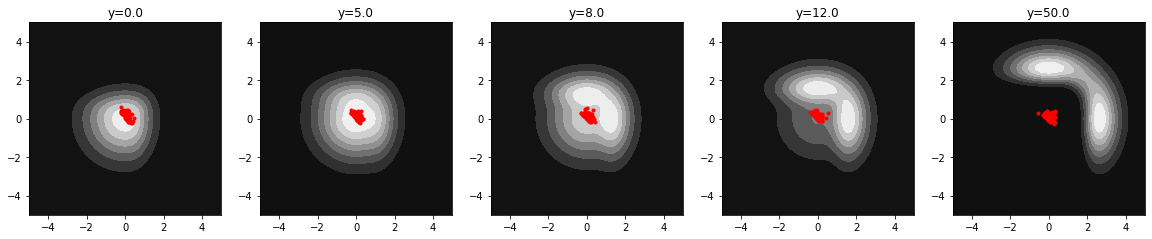

In [4]:
#plotting posteriors for different observed y values
plt.subplots(figsize=(20,4))
for i, yi in enumerate(y):
    plt.subplot(1,5,i+1)
    plt.contourf(xrange, xrange, np.exp(logprior + likelihood(x, yi)).reshape(300,300), cmap='gray')
    plt.title('y={}'.format(yi))
    plt.axis('square');
    z_q = recognition([np.array(100*[yi]).astype('float32').reshape((100, 1)), jc_vi.noise.sample(100)])
    plt.plot(z_q[:,0], z_q[:,1],'r.')
    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])

In [5]:
data = generator(ed.Normal(loc=tf.zeros([10000, 2]), scale=np.sqrt(prior_variance) * tf.ones([10000, 2])))
dataset = tf.data.Dataset.from_tensor_slices(data).repeat(3000)
jc_vi.fit(dataset.batch(256, drop_remainder=True),
          steps_per_epoch=40,
          discriminator_steps=30)


Epoch 1 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.1098 - -log(q): 0.5649
Epoch 2 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3031 - -log(q): 0.2060 ETA: 1s - cross - ETA: 0s - cross_entropy: 1.3002 - -
Epoch 3 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3421 - -log(q): 0.1183
Epoch 4 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3516 - -log(q): 0.0753
Epoch 5 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3584 - -log(q): 0.0651
Epoch 6 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3641 - -log(q): 0.0669
Epoch 7 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3661 - -log(q): 0.0486
Epoch 8 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3664 - -log(q): 0.0588 ETA: 1s
Epoch 9 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3710 - -log(q):

39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3813 - -log(q): 0.0076
Epoch 61 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3803 - -log(q): 0.0079
Epoch 62 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3814 - -log(q): 0.0130
Epoch 63 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3819 - -log(q): 0.0093
Epoch 64 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3792 - -log(q): 0.0143
Epoch 65 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3814 - -log(q): 0.0112
Epoch 66 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3820 - -log(q): 0.0081
Epoch 67 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3810 - -log(q): 0.0122
Epoch 68 of 98
39/40 [============================>.] - ETA: 0s - cross_entropy: 1.3795 - -log(q): 0.0145
Epoch 69 of 98
39/40 [============================>.] - ETA: 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



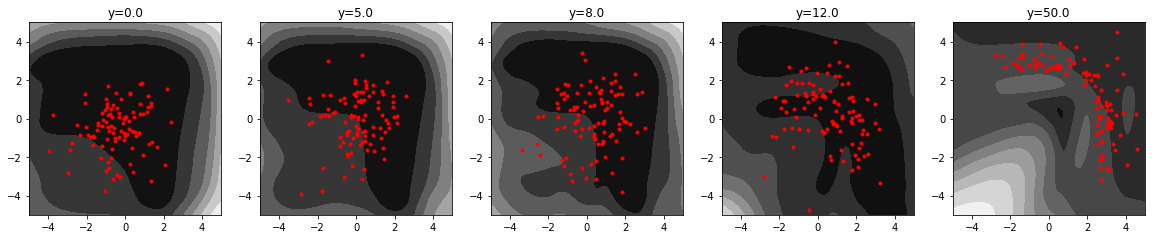

In [6]:
# plotting discriminators for different observed y values
N = 100
q_samples = recognition([np.repeat(np.array(y), N).reshape(len(y)*N, 1), jc_vi.noise.sample(len(y)*N)])
q_samples = q_samples.numpy().reshape(len(y), N, 2)

prior_samples = ed.Normal(loc=tf.zeros([len(y), N, 2]),
                          scale=np.sqrt(prior_variance) * tf.ones([len(y), N, 2]))
plt.subplots(figsize=(20,4))
for i in range(5):
    foobar = discriminator([y[i]*np.ones((90000, 1)), x.T]).numpy()
    plt.subplot(1,5,i+1)
    plt.contourf(xrange, xrange, foobar[:,0].reshape(300,300).T, cmap='gray')
    plt.title('y={}'.format(y[i]))
    plt.axis('square');
    plt.plot(q_samples[i,:,0],q_samples[i,:,1],'r.')

    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])

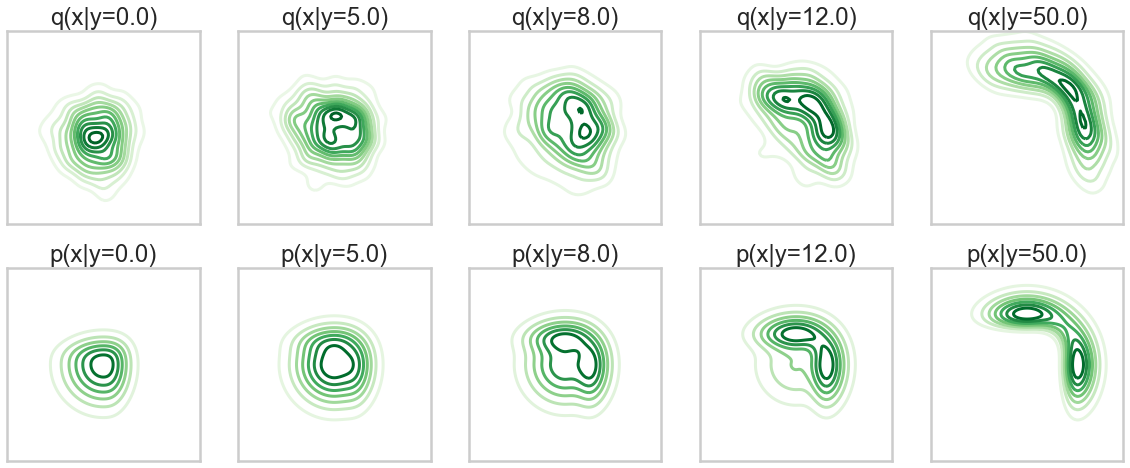

In [7]:
#approximate posteriors for different observed y values
sns.set_style('whitegrid')
sns.set_context('poster')
plt.subplots(figsize=(20,8))
N = 1000
for i, yi in enumerate(y):
    plt.subplot(2,5,i+1)
    samples = recognition([np.array(N*[yi]).reshape((N, 1)), jc_vi.noise.sample(N)])
    sns.kdeplot(samples[:, 0].numpy(), samples[:, 1].numpy(), cmap='Greens')
    plt.axis('square');
    plt.title('q(x|y={})'.format(yi))
    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])
    plt.xticks([])
    plt.yticks([]);
    
    plt.subplot(2,5,5+i+1)
    plt.contour(xrange, xrange, np.exp(logprior+likelihood(x, yi)).reshape(300,300).T, cmap='Greens')
    plt.axis('square');
    plt.title('p(x|y={})'.format(y[i]))
    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])
    plt.xticks([])
    plt.yticks([]);